In [1]:
import wrangle

import pandas as pd
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
df = wrangle.wrangle_zillow()

DataFrame head: 

   parcelid  basementsqft            bathrooms             bedrooms  \
0  14297519           NaN                 3.50                 4.00   
1  17052889           NaN                 1.00                 2.00   
2  14186244           NaN                 2.00                 3.00   

     calculatedbathnbr  finishedfloor1squarefeet  \
0                 3.50                       NaN   
1                 1.00                  1,465.00   
2                 2.00                       NaN   

   calculatedfinishedsquarefeet  finishedsquarefeet12  finishedsquarefeet13  \
0                      3,100.00              3,100.00                   NaN   
1                      1,465.00              1,465.00                   NaN   
2                      1,243.00              1,243.00                   NaN   

   finishedsquarefeet15  ...   censustractandblock             logerror  \
0                   NaN  ... 60,590,630,072,012.00                 0.03   
1                   N

In [11]:
df.transactiondate = pd.to_datetime(df.transactiondate, infer_datetime_format=True) 

# remove one transaction where date is in 2018
df = df[df.transactiondate < '2018-01-01']

# create column with fips value converted from an integer to the county name string
df['county'] = df.fips.map({6037 : 'Los Angeles', 6059 : 'Orange', 6111 : 'Ventura'})




In [12]:
train,validate,test = wrangle.my_split(df)

# what is the distribution of our target variable, LogError?

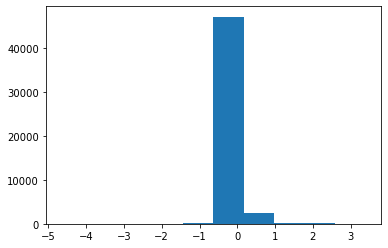

In [13]:
plt.hist(df.logerror)
plt.show()

In [14]:
train.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsize',
       'propertycountylandusecode', 'propertyzoningdesc', 'tract',
       'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc',
       'county'],
      dtype='object')

# Does the logerror differ by county?

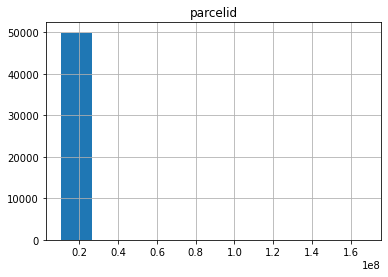

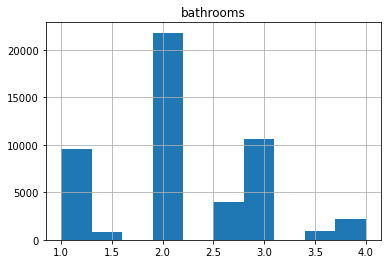

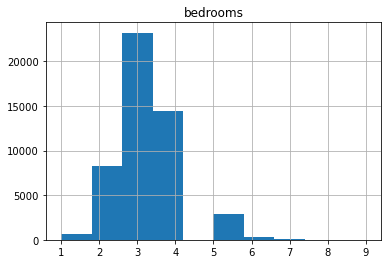

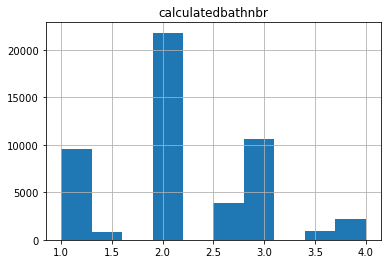

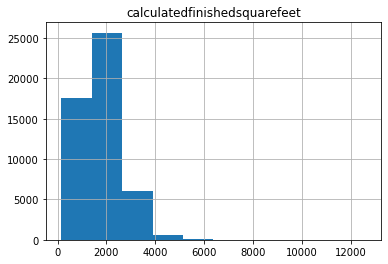

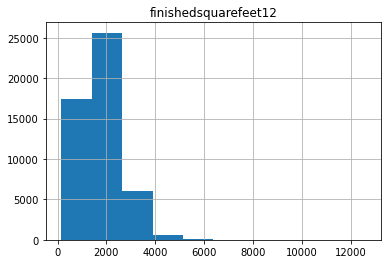

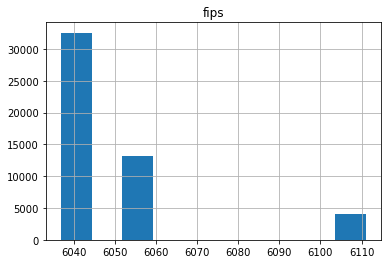

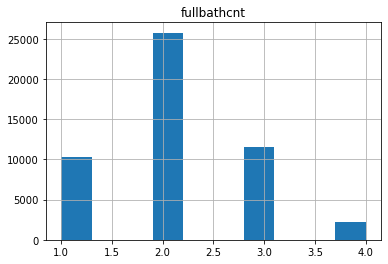

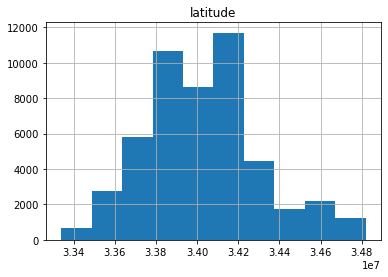

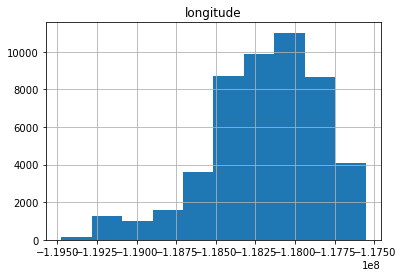

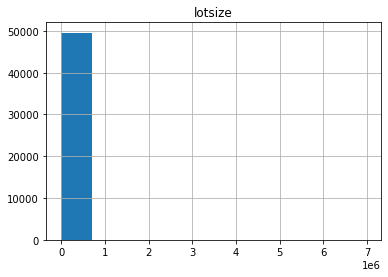

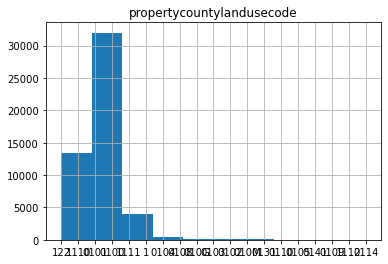

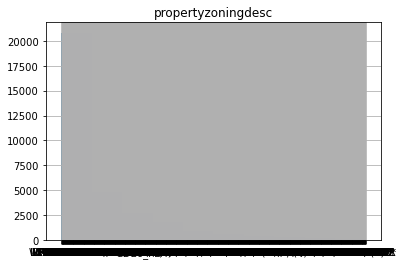

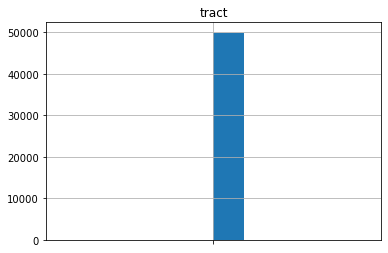

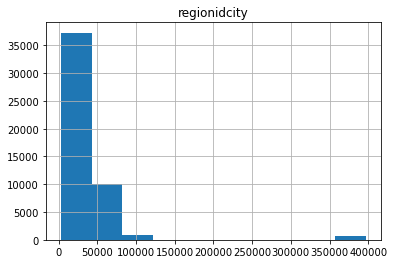

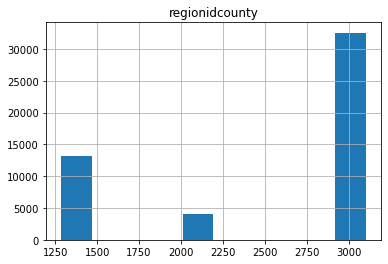

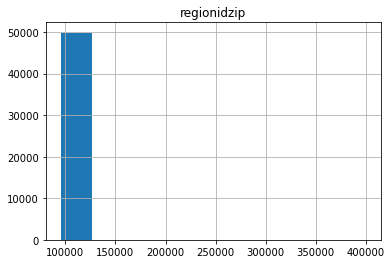

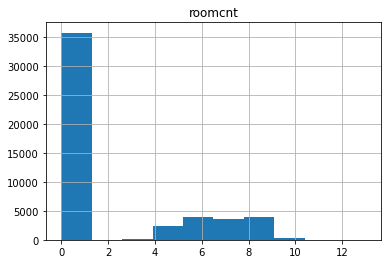

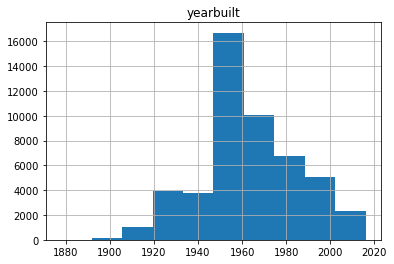

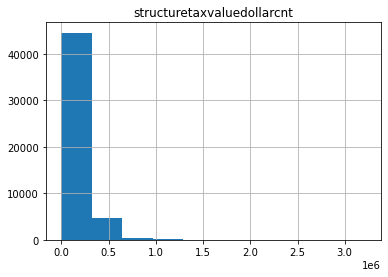

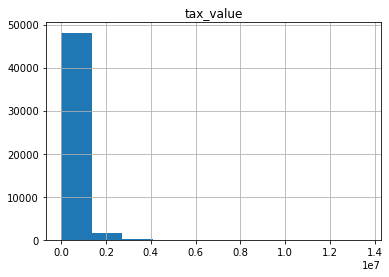

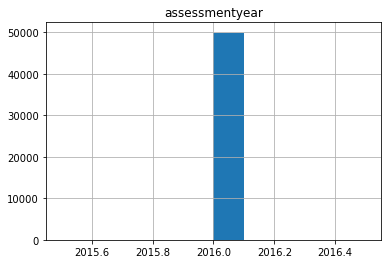

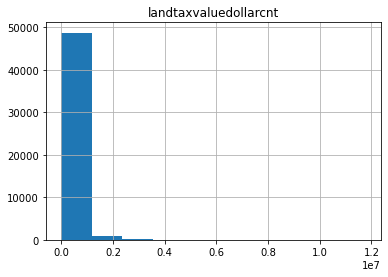

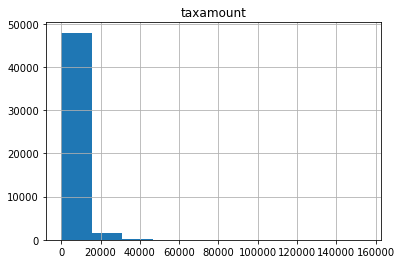

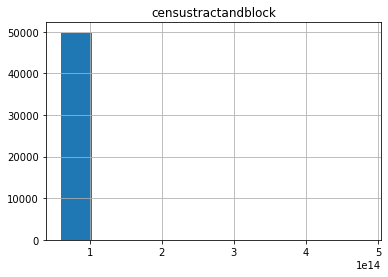

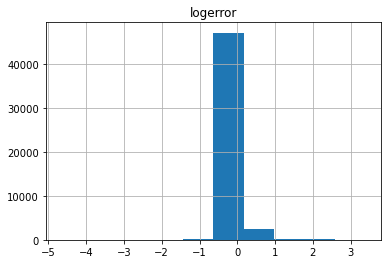

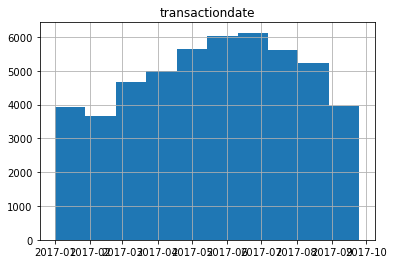

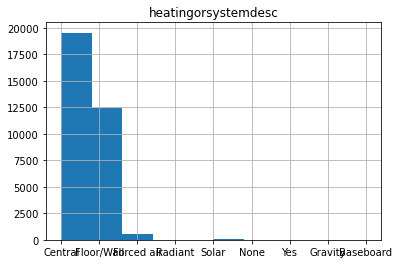

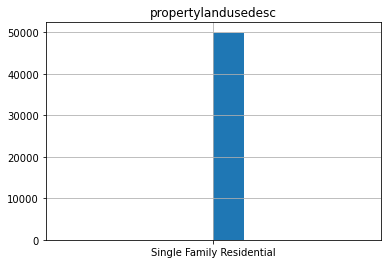

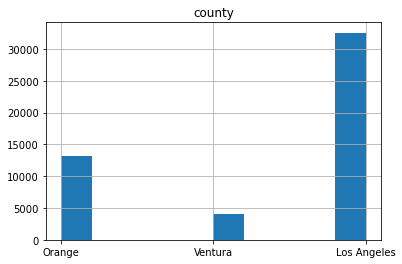

In [66]:
for col in df.columns:
    df[col].hist()
    plt.title(col)
    plt.show()

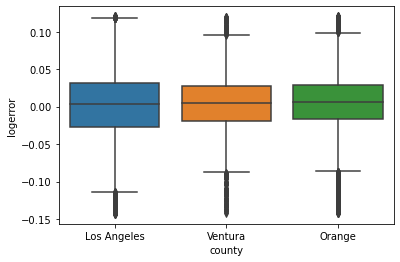

In [171]:
#barplot
sns.boxplot(data=train, x='county', y='logerror')
plt.show()

In [18]:
# test for variance
t, p = stats.levene(train[train.county=='Ventura'].logerror, train[train.county=='Orange'].logerror)
print(t,p)

2.704412918029678 0.10010128958469651


In [170]:
orange = train[train.county == 'Orange']
ventura = train[train.county == 'Ventura']
la = train[train.county == 'Los Angeles']

H0 = 'there is no difference in mean log error for each county'
alpha = .05
f, p = stats.f_oneway(orange.inverselogerror, ventura.inverselogerror, la.inverselogerror) 
if p < alpha:
    print("We reject the Null Hypothesis that", H0)
else:
    print("We confirm the Null Hypothesis that", H0)

We reject the Null Hypothesis that there is no difference in mean log error for each county


# Does log error change with property value?  Controlling for county?

<Figure size 864x576 with 0 Axes>

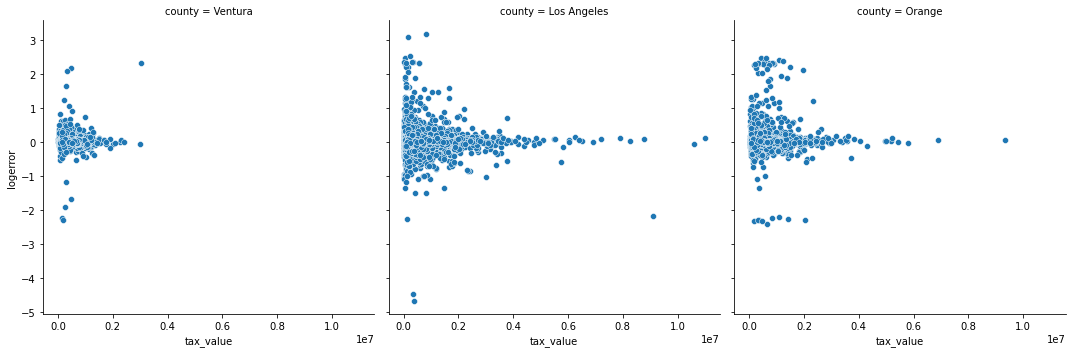

In [56]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.relplot(data=train, x='tax_value', y='logerror', col='county')
plt.show()

In [34]:
stats.spearmanr(train.logerror, train.tax_value)

SpearmanrResult(correlation=-0.0004393803265548724, pvalue=0.9394114404013646)

In [57]:
H0 = 'there is no LINEAR correlation between log error and tax_value'
alpha = .05
f, p = stats.spearmanr(train.logerror, train.tax_value)
if p < alpha:
    print("We reject the Null Hypothesis that", H0)
else:
    print("We confirm the Null Hypothesis that", H0)

We confirm the Null Hypothesis that there is no LINEAR correlation between log error and tax_value


<Figure size 864x576 with 0 Axes>

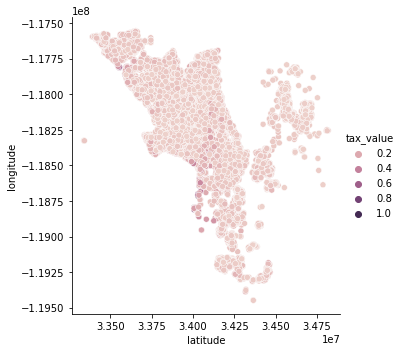

In [73]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.relplot(data=train, x='latitude', y='longitude', hue='tax_value')
plt.show()

In [41]:
train['abslogerror'] = abs(train.logerror)

In [52]:
train['inverselogerror'] = 10**(train.logerror)

AttributeError: module 'seaborn' has no attribute 'hist'

In [62]:
train.inverselogerror.describe()

count              29,929.00
mean                    1.46
std                    13.31
min                     0.00
25%                     0.94
50%                     1.02
75%                     1.09
max                 1,498.61
Name: inverselogerror, dtype: float64

In [63]:


q1, q3 = train['inverselogerror'].quantile([.25, .75]) # get range

iqr = q3 - q1   # calculate interquartile range

upper_bound = q3 + 1.5 * iqr   # get upper bound
lower_bound = q1 - 1.5 * iqr   # get lower bound

train = train[(train['inverselogerror'] > lower_bound) & (train['inverselogerror'] < upper_bound)]

In [64]:
train.inverselogerror.describe()

count              26,362.00
mean                    1.01
std                     0.11
min                     0.72
25%                     0.95
50%                     1.01
75%                     1.07
max                     1.32
Name: inverselogerror, dtype: float64

<AxesSubplot:>

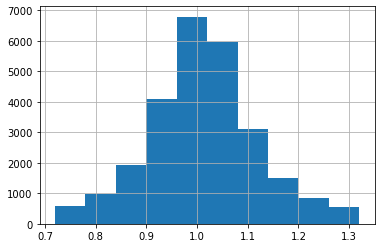

In [65]:
train.inverselogerror.hist()

<Figure size 864x576 with 0 Axes>

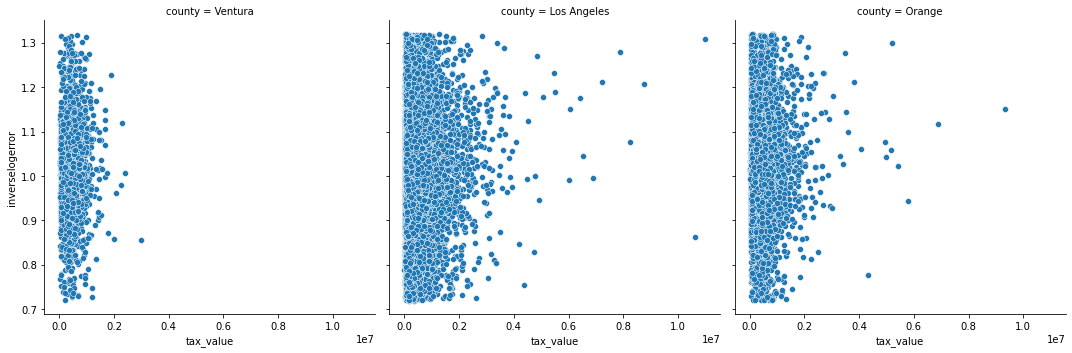

In [67]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.relplot(data=train, x='tax_value', y='inverselogerror', col='county')
plt.show()

In [74]:
train.to_csv('train.csv')

In [77]:
cols = train._get_numeric_data().columns.values.tolist()

In [121]:
cols = [
 'bathrooms',
 'bedrooms',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'latitude',
 'longitude',
 'lotsize',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'tax_value',
 'landtaxvaluedollarcnt',
 'censustractandblock',
 'inverselogerror',
 'abslogerror']

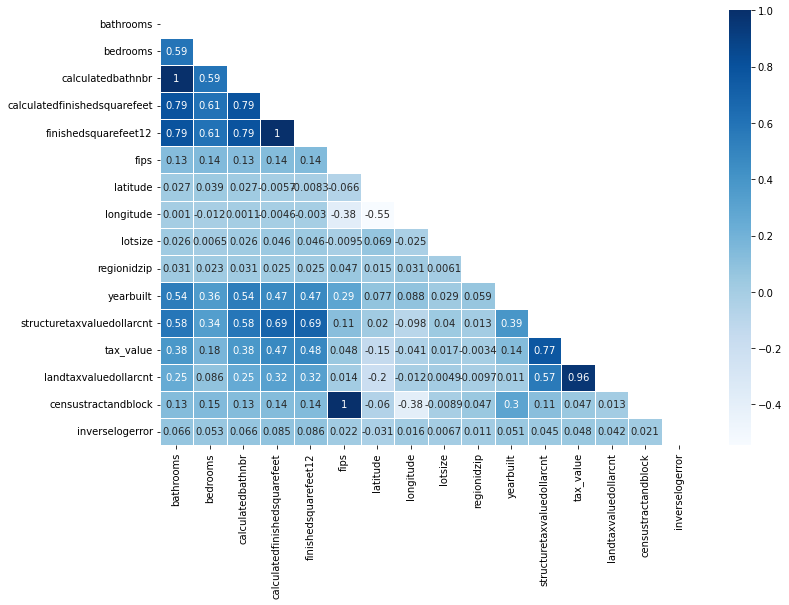

In [103]:

df_corr = train[cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, cmap='Blues', annot = True, mask= np.triu(df_corr), linewidth=.5)
plt.show()

roomcnt, zipcode, tax_value, year, 

In [97]:
train.shape

(26362, 32)

In [102]:
train = train.dropna(subset=['regionidzip'])


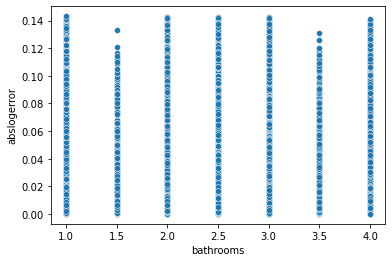

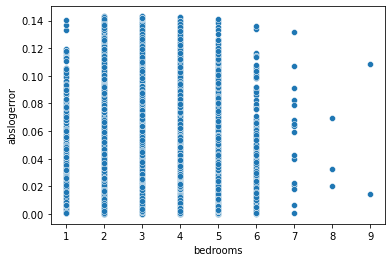

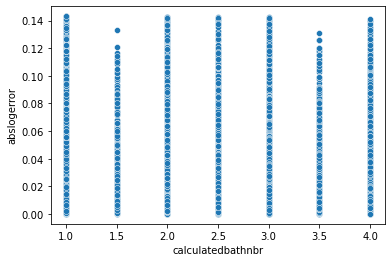

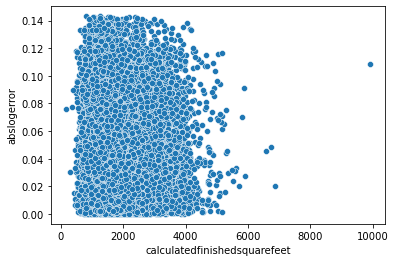

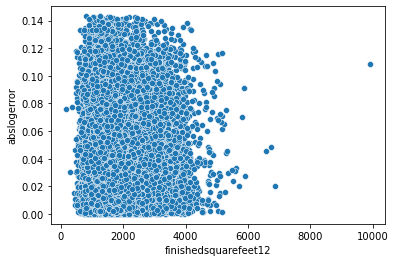

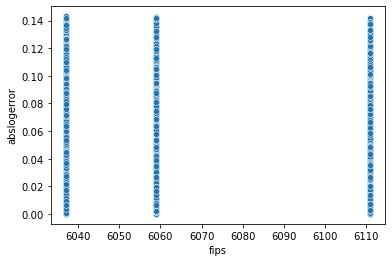

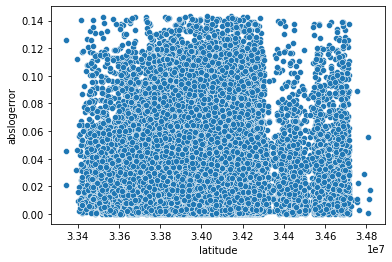

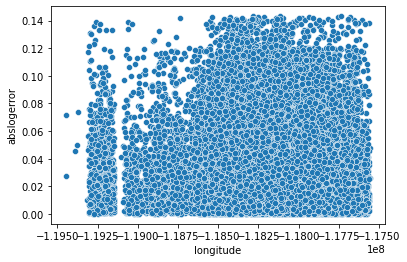

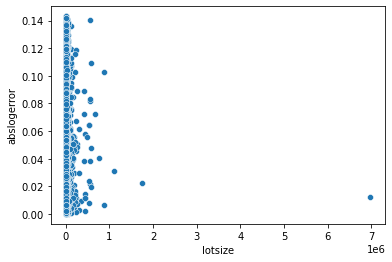

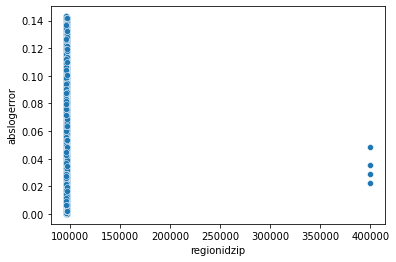

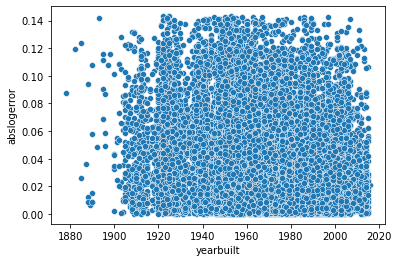

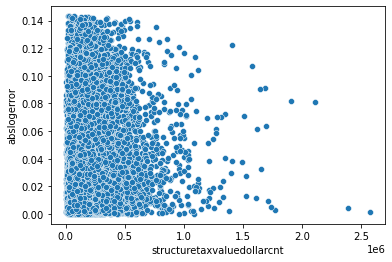

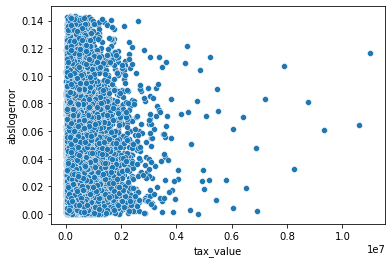

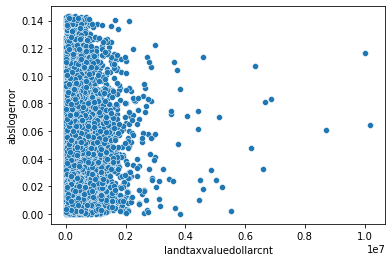

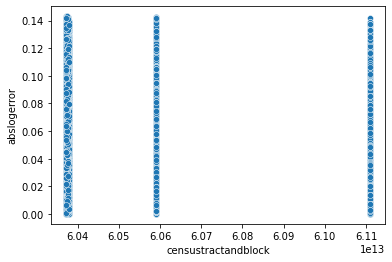

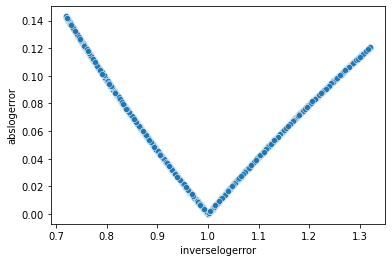

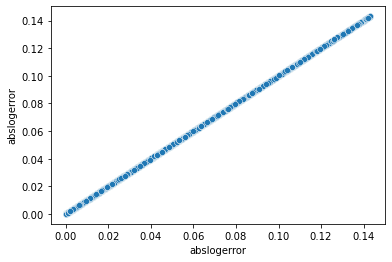

In [123]:
for col in cols:
    sns.scatterplot(data=train, x=col, y='abslogerror')
    plt.show()

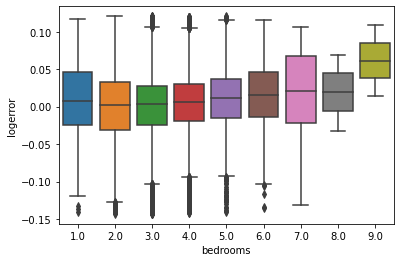

In [177]:
#barplot
sns.boxplot(data=train, x='bedrooms', y='logerror')
plt.show()

In [180]:
oneBR = train[train.bedrooms == 1]
twoBR = train[train.bedrooms == 2]
threeBR = train[train.bedrooms == 3]
fourBR = train[train.bedrooms == 4]
fiveBR = train[train.bedrooms == 5]
sixBR = train[train.bedrooms == 6]
sevenBR = train[train.bedrooms == 7]
eightBR = train[train.bedrooms == 8]
nineBR = train[train.bedrooms == 9]



H0 = 'there is no difference in mean log error for number of BRs'
alpha = .05
f, p = stats.f_oneway(oneBR.logerror, twoBR.logerror, threeBR.logerror, fourBR.logerror, fiveBR.logerror, 
                     sixBR.logerror, sevenBR.logerror, eightBR.logerror, nineBR.logerror) 
if p < alpha:
    print("We reject the Null Hypothesis that", H0)
else:
    print("We confirm the Null Hypothesis that", H0)

We reject the Null Hypothesis that there is no difference in mean log error for number of BRs


In [127]:
len(zips)

374

# Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [108]:
zips = set(train.regionidzip.tolist())

In [126]:
output = []

for zipcode in zips:
    subset = train[train.regionidzip == zipcode]
    alpha = .05

    t,p = stats.ttest_1samp(subset.logerror, train.logerror.mean())
    
    if (p/2 < alpha) and t > 0:
        # reject null hyp, mean is significantly different
        output.append(int(zipcode))
print(output)

[96268, 96337, 96339, 96342, 96373, 96374, 96378, 96387, 96398, 96464, 96469, 96480, 96490, 96492, 96494, 96505, 96513, 399675, 96940, 96952, 96954, 96958, 96959, 96969, 96971, 96981, 96982, 96985, 96987, 96989, 96993, 96995, 97026, 97027, 97040, 97067, 97068, 97099, 97106, 97113, 97298, 97316, 97324, 96009, 96097, 96103, 96116, 96122, 96128, 96203, 96215, 96217, 96220, 96221, 96226]


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [155]:
train.censustractandblock.isnull().sum()

4

In [156]:
train = train.dropna(subset=['censustractandblock'])


In [153]:
train['censustractandblock'] = train.censustractandblock.str[4:]

/var/folders/n4/vxf6h6dx5xxdnkswdp5hx6hh0000gn/T/ipykernel_65759/3060940696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['censustractandblock'] = train.censustractandblock.str[4:]


In [159]:
train.censustractandblock = train.censustractandblock.astype(int)

ValueError: invalid literal for int() with base 10: '002017.0'

In [166]:
train.censustractandblock = train.censustractandblock.str[:6]

/var/folders/n4/vxf6h6dx5xxdnkswdp5hx6hh0000gn/T/ipykernel_65759/692597279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.censustractandblock = train.censustractandblock.str[:6]


In [167]:
train.censustractandblock

36748    002017
67550    063015
17678    022002
25780    102008
29518    243005
          ...  
38423    001008
56922    011021
24955    091004
74387    292006
14132    013002
Name: censustractandblock, Length: 26316, dtype: object

In [168]:
tracts = set(train.censustractandblock.tolist())
output = []

for tract in tracts:
    subset = train[train.censustractandblock == tract]
    alpha = .05

    t,p = stats.ttest_1samp(subset.logerror, train.logerror.mean())
    
    if (p/2 < alpha) and t > 0:
        # reject null hyp, mean is significantly different
        output.append(int(tract))
print(output)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[21008, 182003, 222006, 34002, 171018, 133017, 462002, 192001, 41014, 311001, 142000, 73006, 34017, 372001, 2021, 61147, 171008, 352006, 221004, 81006, 62000, 62015, 133004, 151015, 321017, 251015, 241008, 33011, 15008, 142013, 132003, 565015, 151033, 312000, 191003, 151009, 131008, 231041, 143001, 271020, 31014, 242000, 124005, 134012, 44011, 143004, 25010, 22025, 72009, 441006, 314014, 131024, 183039, 162004, 141009, 141015, 113007, 152003, 222011, 304004, 62017, 202041, 201104, 161023, 262010, 262005, 11028, 284018, 92015, 112011, 394001, 13017, 382002, 62008, 21021, 211002, 61064, 182000, 101011, 72017, 124012, 2034, 11023, 271016, 212007, 41012, 192010, 431000, 61050, 73017, 6016, 292005, 131009, 343002, 321030, 151002, 42010, 34009, 1017, 2028, 101058, 401008, 143003, 93027, 53006, 61022, 52025, 5023, 283025, 111000, 322004, 272007, 51062, 172018, 371019, 223000, 102013, 83034, 431079, 72014, 262007, 112027, 42012, 41026, 581016, 271008, 421005, 2022, 422016, 221002, 322006, 6202